<a href="https://colab.research.google.com/github/yuujinhwng/AI-vs-Human-made-visual-art/blob/main/30562_Yujin_Hwang_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# create json file named 'kaggle.json':
# {"username":"jennin","key":"efa8c880fc4d5b73b17595c5a0fa8549"}
!pip install kaggle
!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!kaggle datasets download ravidussilva/real-ai-art


Dataset URL: https://www.kaggle.com/datasets/ravidussilva/real-ai-art
License(s): other
100% 9.93G/9.95G [02:10<00:00, 176MB/s]
100% 9.95G/9.95G [02:10<00:00, 82.1MB/s]


In [ ]:
!unzip /content/real-ai-art.zip -d /content/real-ai-art

Streaming output truncated to the last 5000 lines.
  inflating: /content/real-ai-art/Real_AI_SD_LD_Dataset/train/ukiyo_e/adachi-ginko_114.jpg  
  inflating: /content/real-ai-art/Real_AI_SD_LD_Dataset/train/ukiyo_e/adachi-ginko_116.jpg  
  inflating: /content/real-ai-art/Real_AI_SD_LD_Dataset/train/ukiyo_e/adachi-ginko_142.jpg  
  inflating: /content/real-ai-art/Real_AI_SD_LD_Dataset/train/ukiyo_e/adachi-ginko_154.jpg  
  inflating: /content/real-ai-art/Real_AI_SD_LD_Dataset/train/ukiyo_e/adachi-ginko_183.jpg  
  inflating: /content/real-ai-art/Real_AI_SD_LD_Dataset/train/ukiyo_e/adachi-ginko_186.jpg  
  inflating: /content/real-ai-art/Real_AI_SD_LD_Dataset/train/ukiyo_e/adachi-ginko_201.jpg  
  inflating: /content/real-ai-art/Real_AI_SD_LD_Dataset/train/ukiyo_e/adachi-ginko_219.jpg  
  inflating: /content/real-ai-art/Real_AI_SD_LD_Dataset/train/ukiyo_e/adachi-ginko_230.jpg  
  inflating: /content/real-ai-art/Real_AI_SD_LD_Dataset/train/ukiyo_e/adachi-ginko_274.jpg  
  inflating: /conte

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization (Normalizati  (None, 32, 32, 3)         7         
 on)                                                             
                                                                 
 conv2d (Conv2D)             (None, 30, 30, 64)        1792      
                                                                 
 max_pooling2d (MaxPooling2  (None, 15, 15, 64)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 13, 13, 64)        36928     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 6, 6, 64)          0         
 g2D)                                                            
                                                        

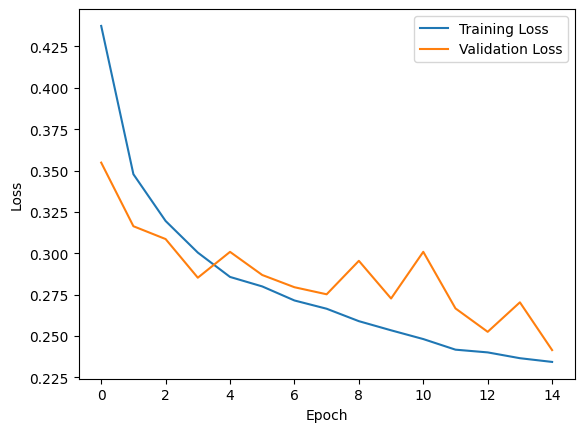

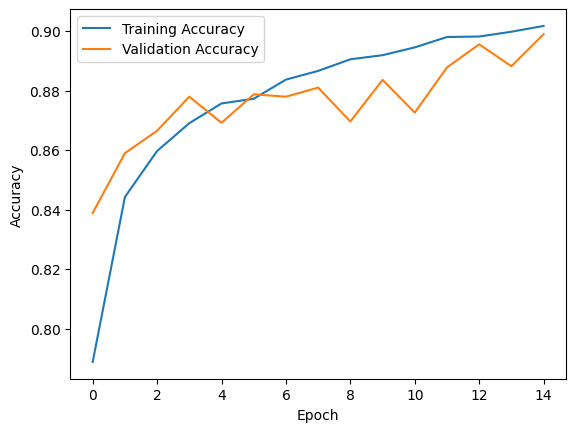

In [ ]:
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
import os
import cv2
from sklearn.model_selection import train_test_split
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Normalization
from keras.models import Sequential
from keras.callbacks import ModelCheckpoint
import time

def initalizing_train(data_dir):
    train_dir = os.path.join(data_dir, 'train')
    list_train_dir = os.listdir(train_dir)
    train_data = pd.DataFrame(columns=['filepath', 'label'])

    train_human = []
    train_ai = []
    filepaths = []
    label = []

    for folder in list_train_dir:
        if folder.startswith('AI_'):
            train_ai.append(os.path.join(train_dir, folder))
        else:
            train_human.append(os.path.join(train_dir, folder))

    for folder in train_human:
        for file in os.listdir(folder):
            filepath = os.path.join(folder, file)
            filepaths.append(filepath)
            label.append("human")

    for folder in train_ai:
        for file in os.listdir(folder):
            filepath = os.path.join(folder, file)
            filepaths.append(filepath)
            label.append("AI")

    file_counts = train_data['label'].value_counts()
    print("\nNumber of files under each label before balance:")
    print(file_counts)

    data = pd.DataFrame({'filepath': filepaths, 'label': label})
    train_data = pd.concat([train_data, data], ignore_index=True)

    random_seed = 777
    np.random.seed(random_seed)

    file_counts = train_data['label'].value_counts()
    num_ai = file_counts.get('AI', 0)
    num_human = file_counts.get('human', 0)
    difference = num_ai - num_human

    if difference > 0:
        ai_indices = train_data[train_data['label'] == 'AI'].index
        drop_indices = np.random.choice(ai_indices, abs(difference), replace=False)
    elif difference < 0:
        human_indices = train_data[train_data['label'] == 'human'].index
        drop_indices = np.random.choice(human_indices, abs(difference), replace=False)

    train_data = train_data.drop(drop_indices)
    train_data.reset_index(drop=True, inplace=True)

    print("Train directories containing human-drawn images:")
    for i, folder in enumerate(train_human):
        print(f"{i}. {folder}")

    print("\nTrain directories containing AI-generated images:")
    for i, folder in enumerate(train_ai):
        print(f"{i}. {folder}")

    file_counts = train_data['label'].value_counts()
    print("\nNumber of files under each label after balance:")
    print(file_counts)

    return train_data

def initalizing_test(data_dir):
    test_dir = os.path.join(data_dir, 'test')
    list_train_dir = os.listdir(test_dir)
    test_data = pd.DataFrame(columns=['filepath', 'label'])

    test_human = []
    test_ai = []
    filepaths = []
    label = []

    for folder in list_train_dir:
        if folder.startswith('AI_'):
            test_ai.append(os.path.join(test_dir, folder))
        else:
            test_human.append(os.path.join(test_dir, folder))

    for folder in test_human:
        for file in os.listdir(folder):
            filepath = os.path.join(folder, file)
            filepaths.append(filepath)
            label.append("human")

    for folder in test_ai:
        for file in os.listdir(folder):
            filepath = os.path.join(folder, file)
            filepaths.append(filepath)
            label.append("AI")

    file_counts = test_data['label'].value_counts()
    print("\nNumber of test files under each label before balance:")
    print(file_counts)

    data = pd.DataFrame({'filepath': filepaths, 'label': label})
    test_data = pd.concat([test_data, data], ignore_index=True)

    random_seed = 777
    np.random.seed(random_seed)

    file_counts = test_data['label'].value_counts()
    num_ai = file_counts.get('AI', 0)
    num_human = file_counts.get('human', 0)
    difference = num_ai - num_human

    if difference > 0:
        ai_indices = test_data[test_data['label'] == 'AI'].index
        drop_indices = np.random.choice(ai_indices, abs(difference), replace=False)
    elif difference < 0:
        human_indices = test_data[test_data['label'] == 'human'].index
        drop_indices = np.random.choice(human_indices, abs(difference), replace=False)

    test_data = test_data.drop(drop_indices)
    test_data.reset_index(drop=True, inplace=True)

    print("Test directories containing human-drawn images:")
    for i, folder in enumerate(test_human):
        print(f"{i}. {folder}")

    print("\nTest directories containing AI-generated images:")
    for i, folder in enumerate(test_ai):
        print(f"{i}. {folder}")

    file_counts = test_data['label'].value_counts()
    print("\nNumber of test files under each label after balance:")
    print(file_counts)

    return test_data


def preprocessing(data_dir):
    train_data = initalizing_train(data_dir)
    train_df, valid_df = train_test_split(train_data, test_size=0.2, shuffle=True, random_state=777, stratify=train_data['label'])
    return train_df, valid_df


def augmentation_train(train_df, valid_df, test_data):
    image_size = (32,32)
    batch = 64
    color = 'rgb'
    training_aug = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255, rotation_range=30,
              horizontal_flip=True,
              vertical_flip=True,
              brightness_range=[0.5, 1.5])

    train_data_gen = training_aug.flow_from_dataframe(
        dataframe = train_df,
        x_col ='filepath',
        y_col ='label',
        target_size = image_size,
        color_mode = color,
        batch_size = batch,
        class_mode ='categorical',
        shuffle =True
    )



    valid_aug = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)

    valid_data_gen = valid_aug.flow_from_dataframe(
              dataframe = valid_df,
              x_col='filepath',
              y_col='label',
              target_size=image_size,
              color_mode=color,
              batch_size=batch,
              shuffle=True,
              class_mode='categorical'
          )

    test_aug = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)
    test_data_gen = test_aug.flow_from_dataframe(
            test_data,
            x_col='filepath',
            y_col='label',
            target_size=image_size,
            color_mode=color,
            batch_size=batch,
            shuffle=False,
            class_mode='categorical'
        )

    print("Shape of test images:", test_data_gen.image_shape)
    print("Shape of augmented training images:", train_data_gen.image_shape)
    print("Shape of validation images:", valid_data_gen.image_shape)
    print("training data class index:", train_data_gen.class_indices)
    print("test data class index:", test_data_gen.class_indices)
    return train_data_gen, valid_data_gen, test_data_gen

def build_network():
    num_classes = 2
    input_shape = (32, 32, 3)
    network = Sequential()
    network.add(Normalization(input_shape=input_shape))
    network.add(Conv2D(filters=64, kernel_size=3, activation='relu'))
    network.add(MaxPooling2D())
    network.add(Conv2D(filters=64, kernel_size=3, activation='relu'))
    network.add(MaxPooling2D())
    network.add(Flatten())

    # Fully connected layers
    network.add(Dense(units=64, activation='relu'))

    # Output layer
    network.add(Dense(units=num_classes, activation='softmax'))

    return network

model = build_network()
model.summary()

def compile(network):
    # Compile the model
    optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
    network.compile(optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

    return network

def train_network(model, train_data_gen, valid_data_gen, epochs = 15):
    total_training_time = 0

    # Loop to allow user to continue training
    while True:
        start_time = time.time()

        history = model.fit(
            train_data_gen,
            epochs = epochs,
            validation_data = valid_data_gen
        )

        training_time = time.time() - start_time
        total_training_time += training_time

        user_input = input("Enter 'c' to continue training for more epochs, or any other key to stop: ")

        if user_input != 'c':
            print("Total training time so far: {:.2f} seconds".format(total_training_time))
            return history

        additional_epochs = int(input("Enter the number of additional epochs you want to train for: "))

        epochs += additional_epochs

def evaluate(history):
    train_accuracy = history.history['accuracy']
    val_accuracy = history.history['val_accuracy']
    print("Training Accuracy:", train_accuracy[-1])
    print("Validation Accuracy:", val_accuracy[-1])
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

data_dir = '/content/real-ai-art/Real_AI_SD_LD_Dataset'
train_df, valid_df = preprocessing(data_dir)
test_data = initalizing_test(data_dir)
train_data_gen, valid_data_gen, test_data_gen = augmentation_train(train_df, valid_df, test_data)

model = build_network()
compiled_model = compile(model)

history = train_network(compiled_model, train_data_gen, valid_data_gen)

evaluate(history)